In [1]:
#Library Used in all Code
import numpy as np
import pandas as pd

#Used In Rule of Mixtures
import pymatgen as pymat
import mendeleev as mendel

#Random
np.random.seed(44) # Random Seed1
import random

# PLOTTING (MATPLOTLIB)
%matplotlib inline
import matplotlib.animation as animation
from IPython.display import HTML
from matplotlib import gridspec
import matplotlib

# PLOTTING (PLOTLY)
import plotly 
import plotly.graph_objs as go
from plotly.offline import iplot
plotly.offline.init_notebook_mode(connected=True)

# ML
from lolopy.learners import RandomForestRegressor
from lolopy.metrics import root_mean_squared_error
from lolopy.metrics import standard_error
from sklearn.metrics import mean_absolute_error


# Meltheas TOOL
from simtool import findInstalledSimToolNotebooks, searchForSimTool
from simtool import getSimToolInputs, getSimToolOutputs, Run

MeltHEA = searchForSimTool('meltheas')
from IPython.display import clear_output
from IPython.display import display
from hublib.ui import FileUpload
import ipywidgets as widgets
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

<IPython.core.display.Javascript object>

# Import Initial Dataset 

In [2]:
#Get initial set for testing data
initial_data = pd.read_csv('~/activemeltheas/data/NewSmallCompistionDataSet.csv')

#Remove Columns No Longer Needed
initial_data = initial_data.drop(['Solid Tm'], axis=1)
initial_data = initial_data.drop(['Liquid Tm'], axis=1)
initial_data = initial_data.drop(['Minus'], axis=1)
initial_data = initial_data.drop(['Plus'], axis=1)
initial_data = initial_data.drop(['Unnamed: 0'], axis=1)

#Create Dataset Of Only Compoistions
compared_df = initial_data.drop(['Simulated Tm'], axis=1)

#display(initial_data)

# Initial Set to Refer to

In [3]:
#Create lines to get values with .1 step size
nx = 11
x1 = np.linspace(0, 1, nx)
y, y1, y2, y3, y4 = np.meshgrid(x1, x1, x1, x1, x1)
positions = np.vstack([y.ravel(), y1.ravel(), y2.ravel(), y3.ravel(), y4.ravel()]).T

#Make dataframe with limits of all possible compistions combinations
all_permutations = pd.DataFrame(positions)
all_permutations["sum"]= all_permutations.sum(axis = 1)
plausible_compositions = all_permutations[all_permutations["sum"] == 1]

plausible_compositions = plausible_compositions[plausible_compositions[0] <= 0.5] #Cr
plausible_compositions = plausible_compositions[plausible_compositions[1] <= 0.5] #Co
plausible_compositions = plausible_compositions[plausible_compositions[2] <= 0.5] #Cu
plausible_compositions = plausible_compositions[plausible_compositions[3] <= 0.5] #Fe
plausible_compositions = plausible_compositions[plausible_compositions[4] <= 0.5] #Ni

plausible_compositions = plausible_compositions.round(1)

plausible_compositions = plausible_compositions.drop(["sum"], axis = 1)
initial_plausible_compositions = plausible_compositions
#display(len(plausible_compositions))

# All Plausible Compisition Creator

In [4]:
nx = 51
a = np.linspace(0, 0.5, nx)

results = []

for i in a:
    for j in a:
        for k in a:
            for l in a:
                for m in a:
                    if i+j+k+l+m == 1:
                        results.append([i,j,k,l,m])
                        #print('working')

all_res = pd.DataFrame(results)
#display(all_res)

In [5]:
all_res = all_res[all_res[0] == 0] #Cr
all_res = all_res[all_res[1] <= 0.5] #Co
all_res = all_res[all_res[2] == 0.0] #Cu
all_res = all_res[all_res[3] == 0.5] #Fe
all_res = all_res[all_res[4] <= 0.5] #Ni
all_res = all_res.rename(columns={0:'Cr',1:'Co',2:'Cu',3:'Fe',4:'Ni'})
#print(len(all_res))

# Apply Rule of Mixtures to Compositions

In [6]:
#string to select characteristics
actual_qued_values = ['youngs_modulus', 'atomic_radius', 'electrical_resistivity','CTE','hardness','boiling_point',
                         'atomic_mass','poissons_ratio','density_of_solid','en_gosh','melting_point']

sample = ['Cr', 'Co', 'Cu', 'Fe', 'Ni']

def get_discriptors(input_string,sample):
    #dictionary values to choose from
    string_dict = ['bulk_modulus','youngs_modulus','CTE','thermal_conductivity','boiling_point','critical_temperature',
                  'vdw_radius','average_ionic_radius','atomic_radius','atomic_number','atomic_mass','molar_volume', 
                   'density_of_solid','hardness','poissons_ratio','period','group','en_gosh','electrical_resistivity', 'melting_point']

    #Creation of dictionary
    data_set = {}

    #Make dict of lists
    for length_string in range(len(string_dict)):
        data_set[string_dict[length_string]] = []

    #all plausbile compositions from before
    df2 = plausible_compositions

    #list of all things
    que_values = []

    for item in sample:
        element_object = pymat.Element(item)
        data_set[string_dict[0]].append(element_object.bulk_modulus) #bulk_modulus
        data_set[string_dict[1]].append(element_object.youngs_modulus) #youngs_modulus
        data_set[string_dict[2]].append(element_object.coefficient_of_linear_thermal_expansion) #CTE
        data_set[string_dict[3]].append(element_object.thermal_conductivity) #thermal conductivity
        data_set[string_dict[4]].append(element_object.boiling_point) #boiling_point
        data_set[string_dict[5]].append(element_object.critical_temperature) #critical temperature
        data_set[string_dict[6]].append(element_object.van_der_waals_radius) #vander wall radius
        data_set[string_dict[7]].append(element_object.average_ionic_radius) #average ionic radius
        data_set[string_dict[8]].append(element_object.atomic_radius) #atomic radius
        data_set[string_dict[9]].append(element_object.Z) #atomic number
        data_set[string_dict[10]].append(element_object.atomic_mass) #atomic mass
        data_set[string_dict[11]].append(element_object.molar_volume) #molar volume
        data_set[string_dict[12]].append(element_object.density_of_solid) #density_solid
        data_set[string_dict[13]].append(element_object.brinell_hardness) #brinell_hardness
        data_set[string_dict[14]].append(element_object.poissons_ratio) #poissons_ratio
        data_set[string_dict[15]].append(element_object.row) #period
        data_set[string_dict[16]].append(element_object.group) #group
        data_set[string_dict[17]].append(element_object.X) #en_gosh
        data_set[string_dict[18]].append(element_object.electrical_resistivity) #electrical_resistivity
        data_set[string_dict[19]].append(element_object.melting_point) #melting_point

    for discript in input_string:
        que_values.append(data_set[discript])

    df = pd.DataFrame(data = que_values, columns = sample, index = input_string) 
    display(df)
    return df

discriptors_df = get_discriptors(actual_qued_values,sample)
discriptors_df.to_csv('AdjustedInitialSetData', index = False)

,Cr,Co,Cu,Fe,Ni
youngs_modulus,2.790000e+02,2.090000e+02,1.300000e+02,2.110000e+02,2.000000e+02
atomic_radius,1.400000e+00,1.350000e+00,1.350000e+00,1.400000e+00,1.350000e+00
electrical_resistivity,1.270000e-07,6.000000e-08,1.720000e-08,1.000000e-07,7.200000e-08
CTE,4.900000e-06,1.300000e-05,1.650000e-05,1.180000e-05,1.340000e-05
hardness,1.120000e+03,7.000000e+02,8.740000e+02,4.900000e+02,7.000000e+02
boiling_point,2.944000e+03,3.200000e+03,3.200000e+03,3.134000e+03,3.186000e+03
atomic_mass,5.199610e+01,5.893319e+01,6.354600e+01,5.584500e+01,5.869340e+01
poissons_ratio,2.100000e-01,3.100000e-01,3.400000e-01,2.900000e-01,3.100000e-01
density_of_solid,7.140000e+03,8.900000e+03,8.920000e+03,7.874000e+03,8.908000e+03
en_gosh,1.660000e+00,1.880000e+00,1.900000e+00,1.830000e+00,1.910000e+00


In [7]:
#Rename df to match other dataframes
plausible_compositions = plausible_compositions.rename(columns = {0:'Cr',1:'Co',2:'Cu',3:'Fe', 4:'Ni'})

#Taking out replicas
df = pd.merge(plausible_compositions, compared_df, how='left', indicator = 'Exsist')
df = df[df['Exsist'] != 'both']
plausible_compositions = df.drop(['Exsist'], axis = 1)

#display(plausible_compositions)

# Applying Rule of Mixture

In [8]:
#Applu Rule of Mixtures
def rule_mixtures(df2,df,sample): 
    #Creator column of first rule mixture discriptor to concat to
    cr = 0
    for comps in sample:
        cr = cr+df2[comps]*df[comps][0]
    cr = cr.to_frame()

    #Concat rest of compistions with rule of mixtures applied
    for x in range(1,len(actual_qued_values)):
        cf = 0
        for comps in sample:
            cf = cf + df2[comps]*df[comps][x]
        cf.to_frame()
        cr = pd.concat([cr,cf], axis=1)

    #Renames columns to discriptors
    cr.columns = actual_qued_values
    return cr

plausible_compositions_rule_mixtures = rule_mixtures(plausible_compositions,discriptors_df,sample)
known_compositions_rule_mixtures = rule_mixtures(compared_df,discriptors_df,sample)
CoFeNi_compositions = rule_mixtures(all_res,discriptors_df,sample)
#display(plausible_compositions_rule_mixtures)
#display(known_compositions_rule_mixtures)
#known_compositions_rule_mixtures.to_csv('AdjustedInitialSetData', index = False)

# Data Preperation

In [9]:
#Concatinate values
all_rule_mixtures = pd.concat([known_compositions_rule_mixtures,plausible_compositions_rule_mixtures])
all_compositions = pd.concat([compared_df,plausible_compositions])
all_desired_predictions = pd.concat([known_compositions_rule_mixtures,CoFeNi_compositions])

#Experimental melting temperatures [K]
T_m_Cr = 2180
T_m_Co = 1768
T_m_Cu = 1358
T_m_Fe = 1811
T_m_Ni = 1728

#display(len(all_desired_predictions))

In [10]:
#Set testing and training data
all_values = all_rule_mixtures.values.tolist()
all_labels = initial_data['Simulated Tm'].tolist()

# List of lists are turned into Numpy arrays to facilitate calculations in steps to follow (Normalization).
all_values = np.array(all_values, dtype = float)
all_labels = np.array(all_labels, dtype = float)

create_label = np.zeros((plausible_compositions_rule_mixtures.shape[0],), dtype = int)
all_labels = np.concatenate((all_labels,create_label), axis = 0)
#display(all_compositions)

# Random Forest Creation and Prediction

In [11]:
X = all_values.copy() #discriptors
y = all_labels.copy() #all labels
z = all_desired_predictions.copy() #cofeni compositions

# assign values
model = RandomForestRegressor(num_trees = 350) #model if iterate through
#print(model.__init__)

entry_number_init = initial_data.shape[0] #starting point of initial data
in_train = np.zeros(len(X), dtype=np.bool) #make all false

in_train[:entry_number_init] = True #turns false to true 

#in_train[np.where(y!=0)] = True

print('Picked {} training entries'.format(in_train.sum()))

nsamples = in_train.sum()
train_fraction = 0.8
train_idx = int(train_fraction*nsamples)

print (X.shape, y.shape)  

# Uncomment the line below to shuffle the dataset (we do not do this here to ensure consistent results for every run)
#order = np.argsort(np.random.random(all_labels.shape)) # This numpy argsort returns the indexes that would be used to shuffle a list
#order = np.arange(nsamples)
#all_values = all_values[0:nsamples][order]
#all_labels = all_labels[0:nsamples][order]

model.fit(X[:train_idx, :], y[:train_idx])
test_pred, test_std = model.predict(X[train_idx:nsamples, :], return_std=True)
pred, std = model.predict(z, return_std=True)
#print(in_train)
#print(len(pred))

Picked 39 training entries
(593, 11) (593,)


# Testing Random Forest & Datapoints

In [40]:
#Selecting time to run
time = 200 #Options: 50, 100, 200 (ps)

#Getting CSV & Selecting Points to add
if time == 50:
    initial_data = pd.read_csv('~/activemeltheas/data/50picoRuns_RandomSeeds/Trial1/MLI_melting_50Pico_Final.csv')
    points = [0,7,13,18]
elif time == 100:
    initial_data = pd.read_csv('~/activemeltheas/data/100picoRuns_RandomSeeds/Trial1/MLI_melting_100Pico_Final.csv')
    points = [0,6,11,16]
elif time == 200:
    initial_data = pd.read_csv('~/activemeltheas/data/200picoRuns_RandomSeeds/Trial1/MLI_melting_200Pico_Final.csv')
    points = [0,7,13,18]

#hyperparamter list
stepsize = 50
testTree = 50

#Setting Values
history_train = [list(set(np.where(in_train)[0].tolist()))]
all_inds = set(range(len(y))) #set indexes

#Random Forest fitting and predicting
current_train_inds = history_train[-1].copy()
current_search_inds = list(all_inds.difference(current_train_inds))

predictionsTreeVary = [] #list of predicted values
uncertaintyTreeVary = [] #list of uncertainty values

for testing_points in points:
    
    for points_adding in range(0,testing_points):
        indexing = initial_data['Index'][points_adding]
        y[indexing] = initial_data['Simulated Tm'][points_adding]
        current_train_inds.append(indexing)
        
    predictions = [] #preds
    uncertainty = [] #std
    
    for tree in range(1,int(350/stepsize)+1):
        model = RandomForestRegressor(num_trees = testTree*tree) #model if iterate through
        
        model.fit(X[current_train_inds], y[current_train_inds]) #train model, with entry_number
        pred, std = model.predict(z, return_std=True) #pred
    
        predictions.append(pred)
        uncertainty.append(std)
        #print(testTree*tree)
    
    predictionsTreeVary.append(predictions)
    uncertaintyTreeVary.append(uncertainty)
    

In [41]:
#display(predictionsTreeVary)
#display(uncertaintyTreeVary)

In [42]:
#Get Predictions and Uncertaintity
rinfo_arrayTreeVary = []
properInfo_arrayTreeVary = []

for predictions,uncertainty in zip(predictionsTreeVary,uncertaintyTreeVary):
    
    rinfo_array = [] #dataframe of uncertainty & pred
    properInfo_array = [] #adjust to include proper values
    
    for array in range(0,len(predictions)):
        rfinfo = pd.DataFrame(data = np.transpose([predictions[array][len(initial_data)-1:],uncertainty[array][len(initial_data)-1:]]), columns = ['InitialRFPrediction','InitialRFUncertaintity'])
        properInfo = pd.concat([rfinfo,all_res.reset_index()],axis=1,ignore_index = False)
        rinfo_array.append(rfinfo)
        properInfo_array.append(properInfo)
    
    rinfo_arrayTreeVary.append(rinfo_array)
    properInfo_arrayTreeVary.append(properInfo_array)


# MD and RF Graph

# Single Graphs

/apps/share64/debian7/anaconda/anaconda-6/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



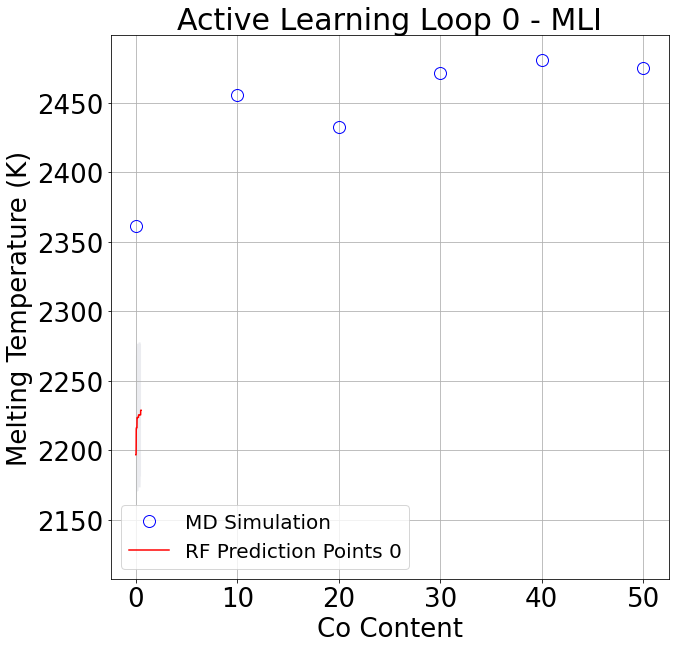

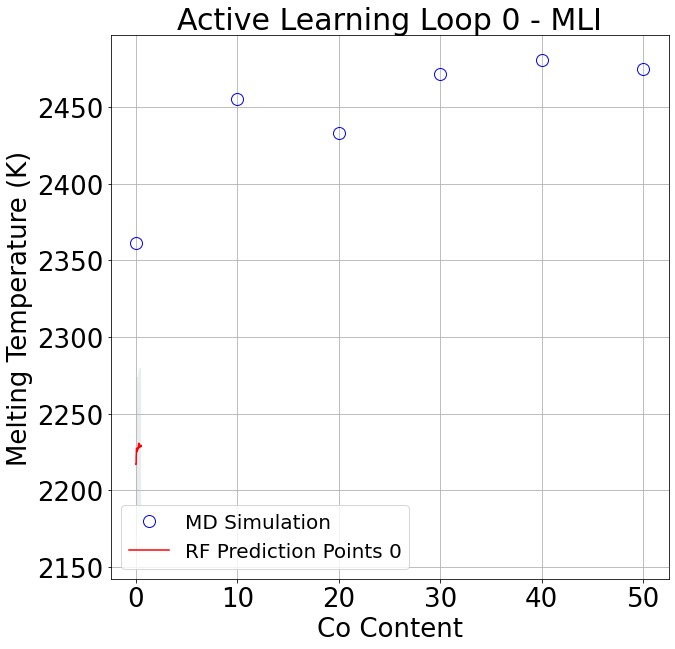

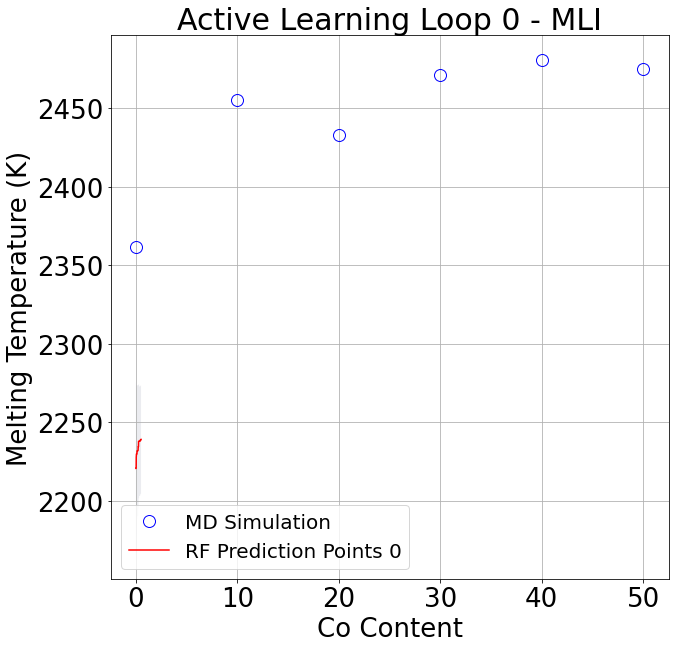

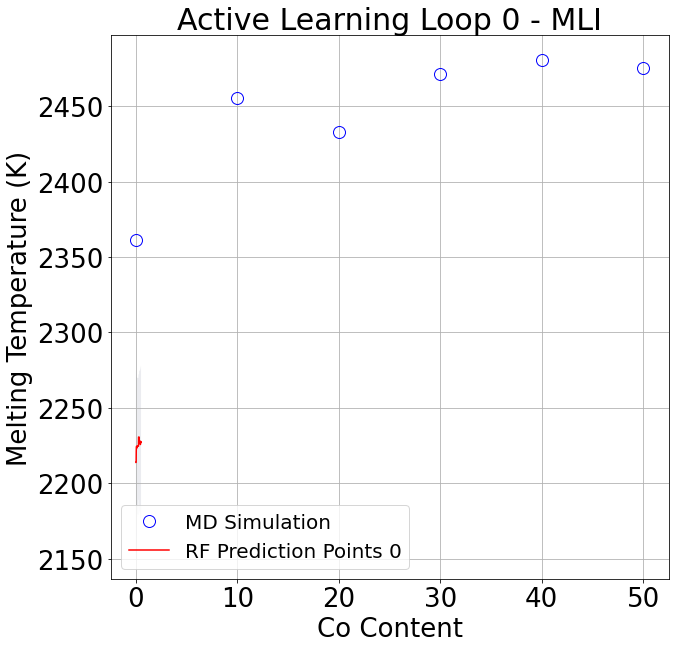

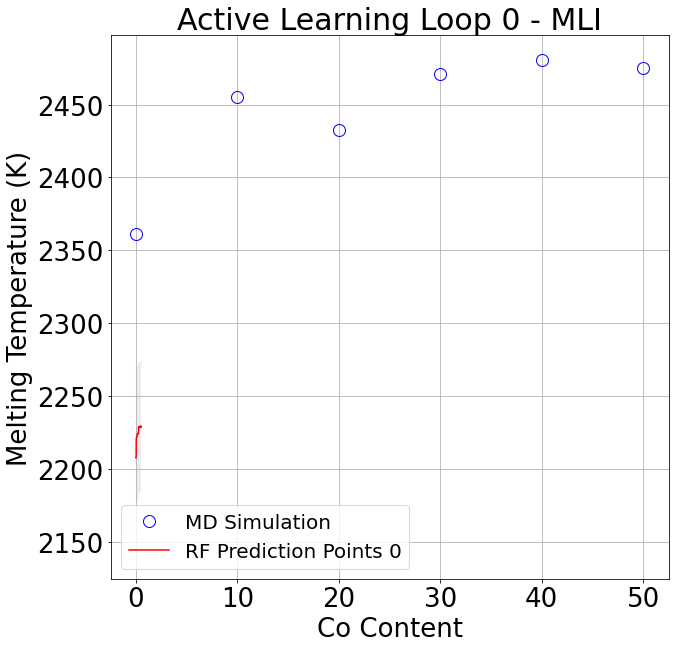

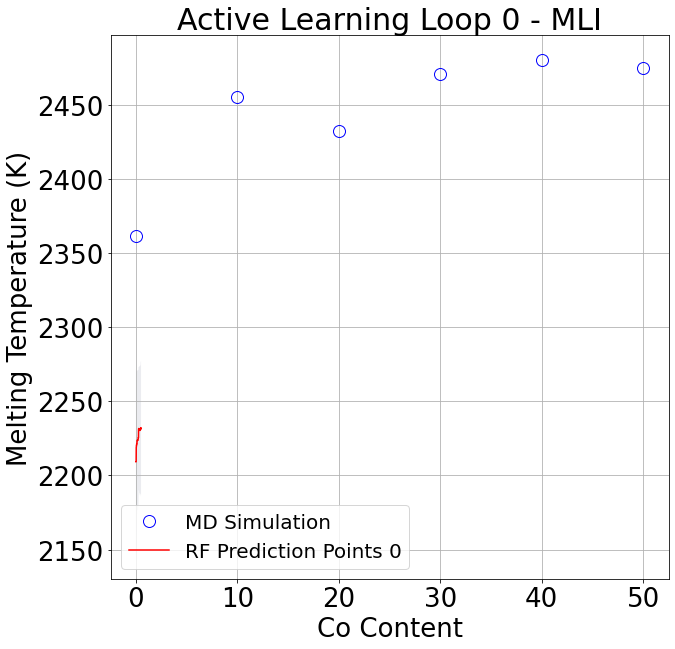

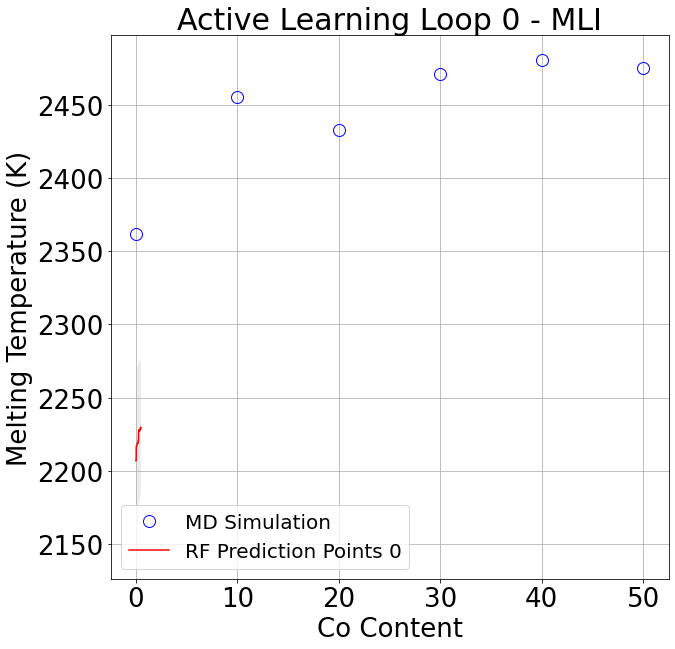

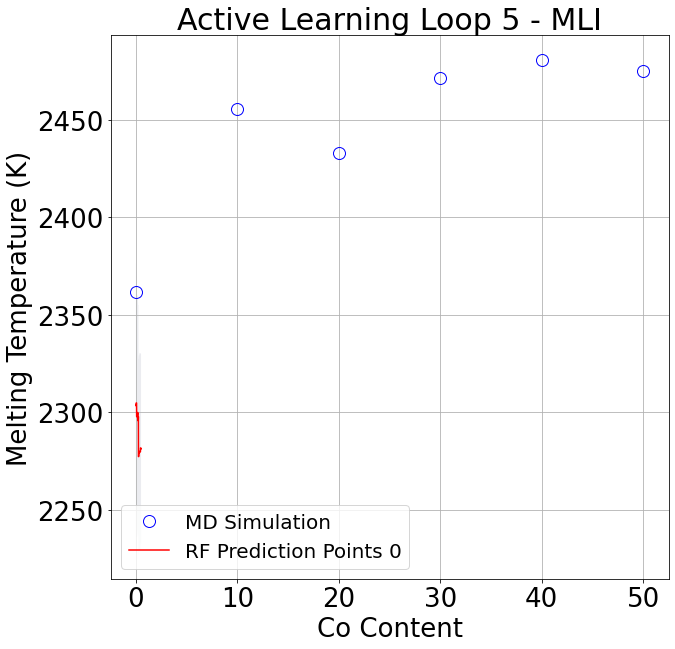

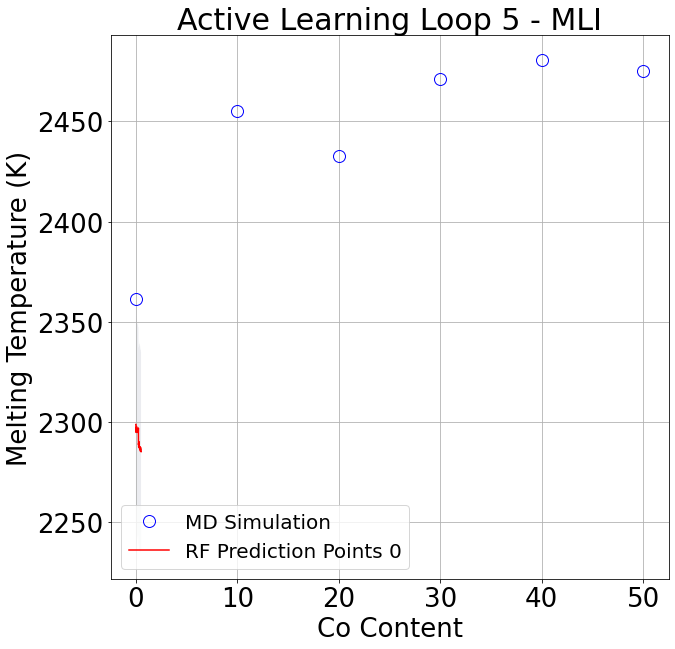

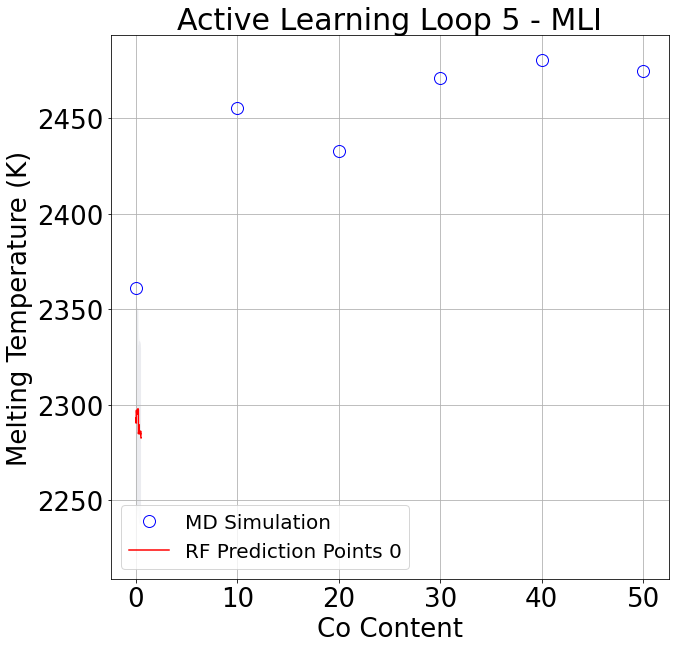

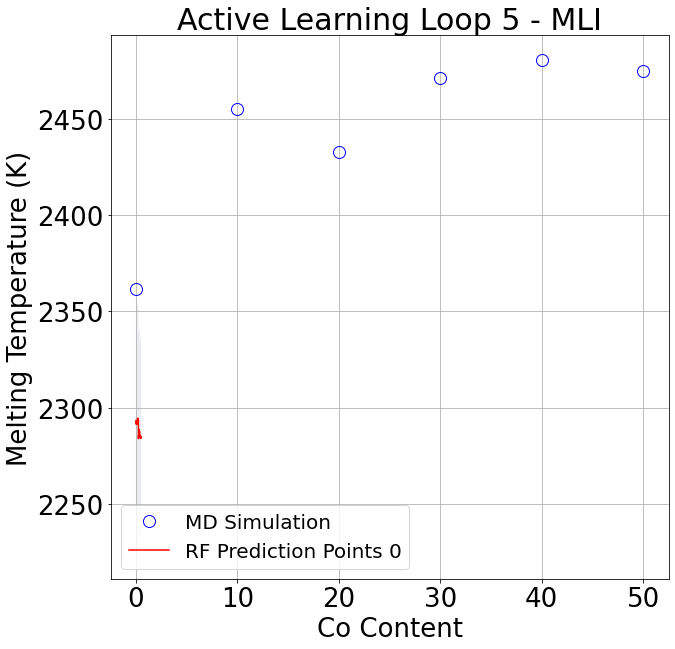

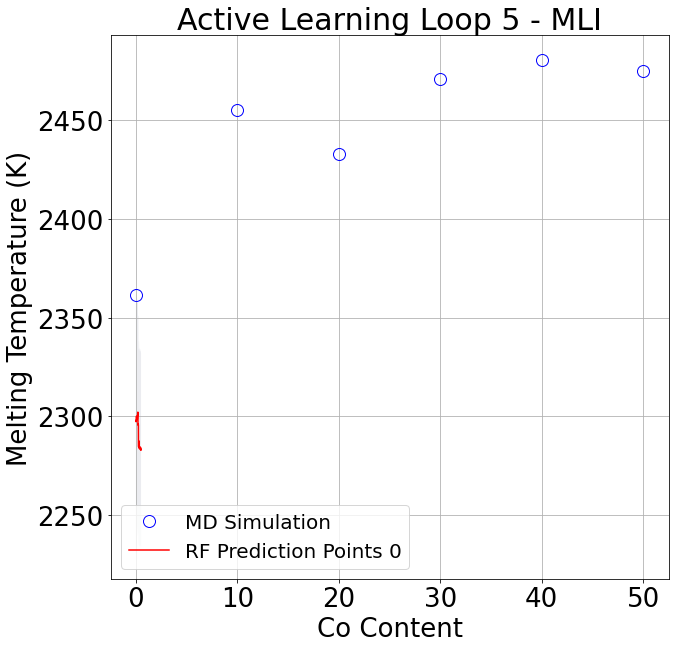

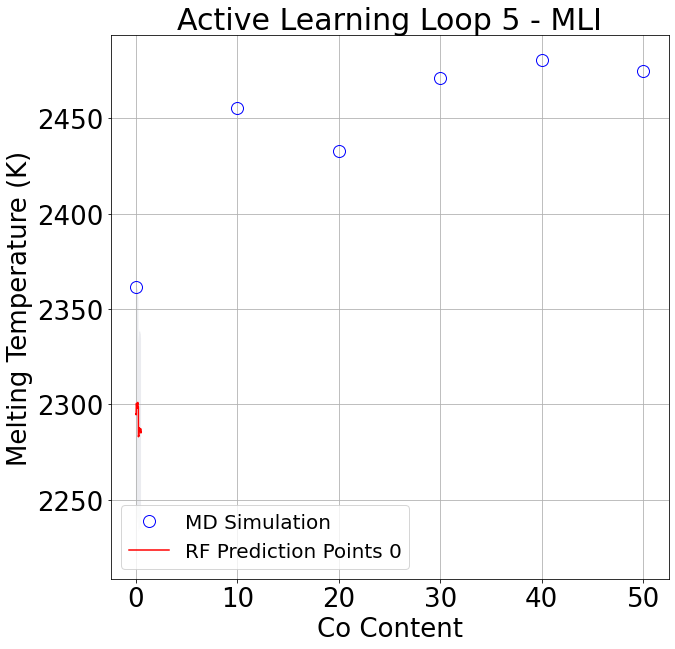

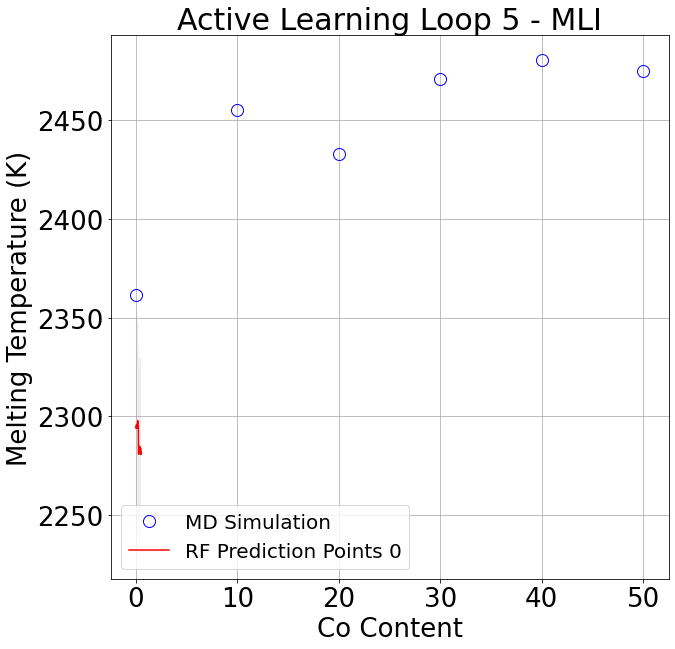

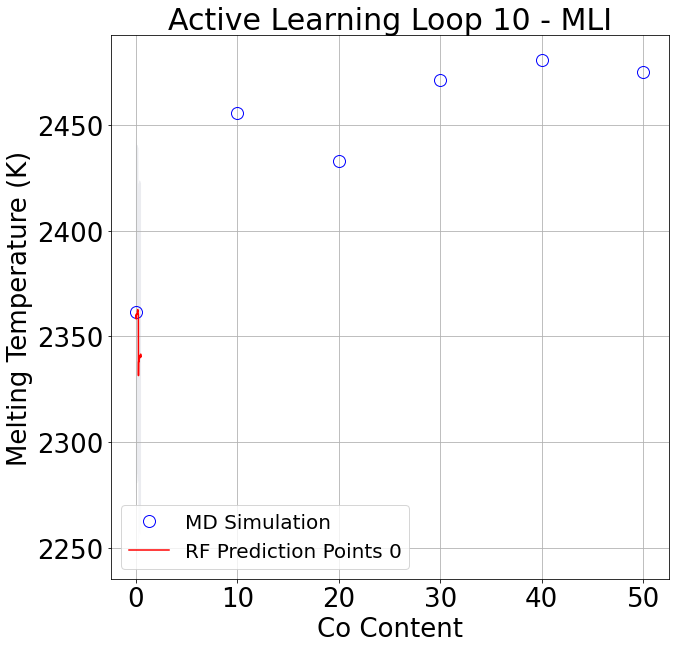

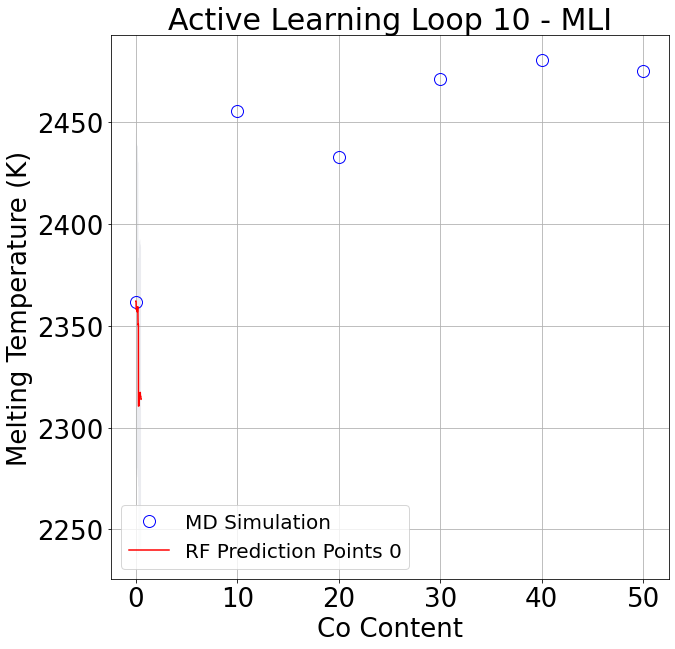

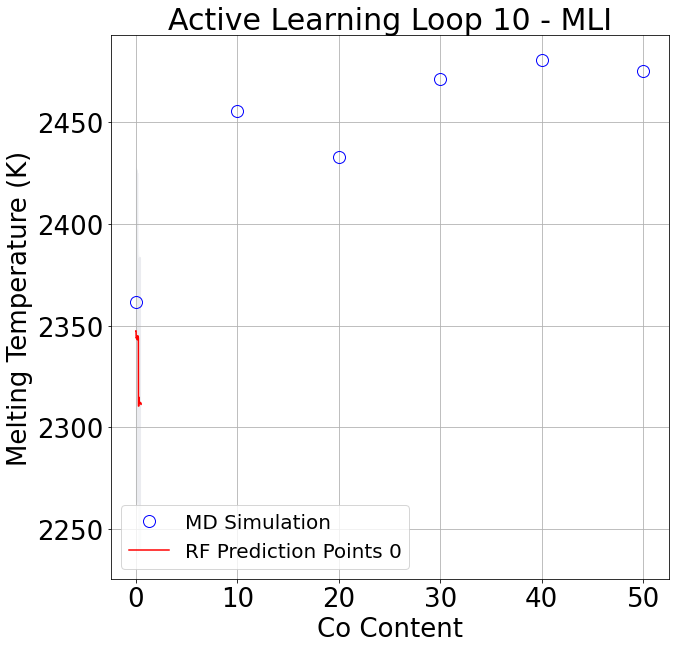

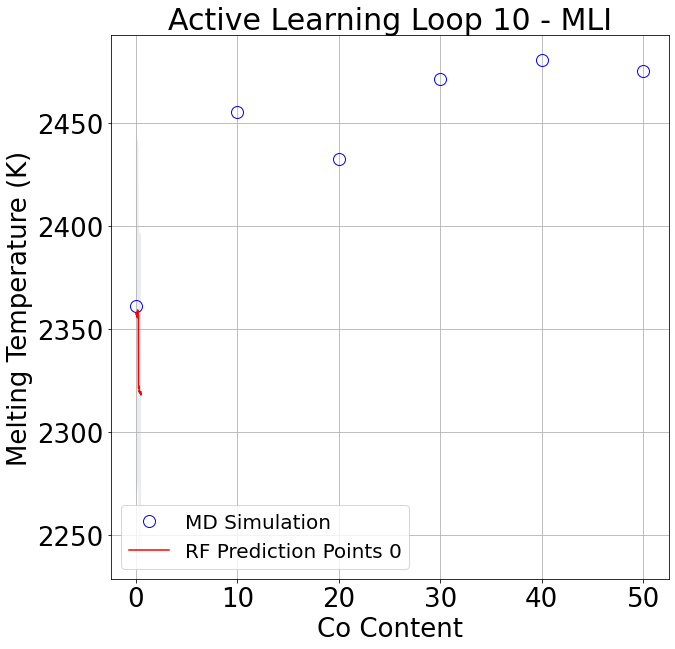

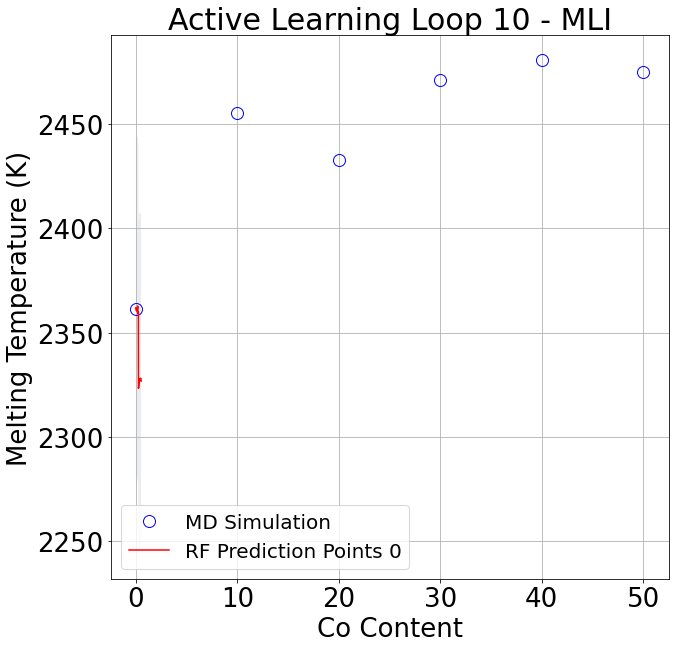

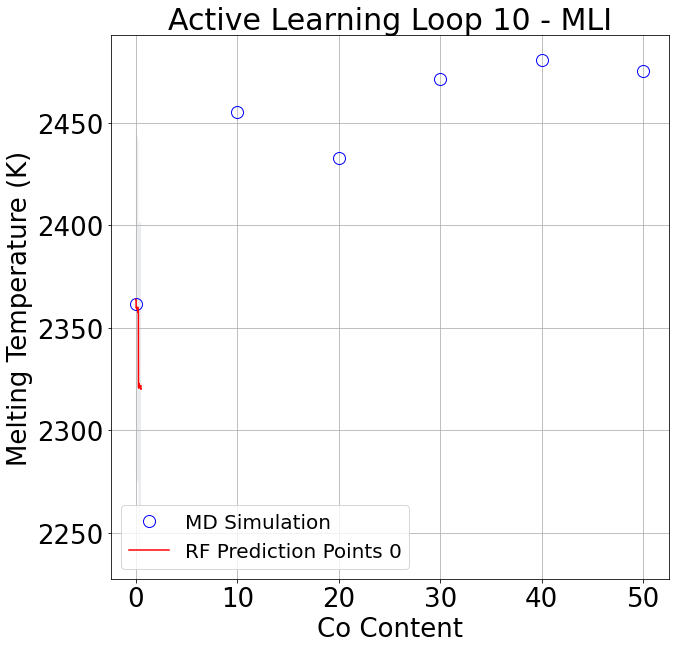

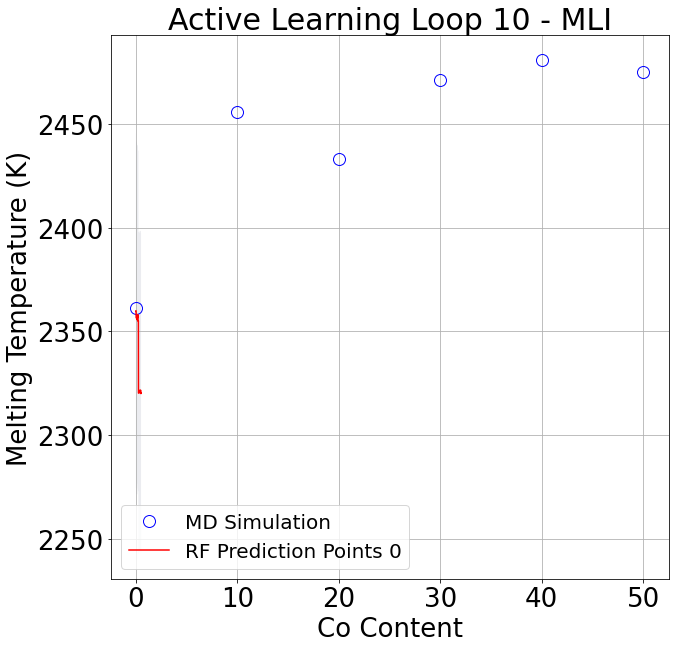

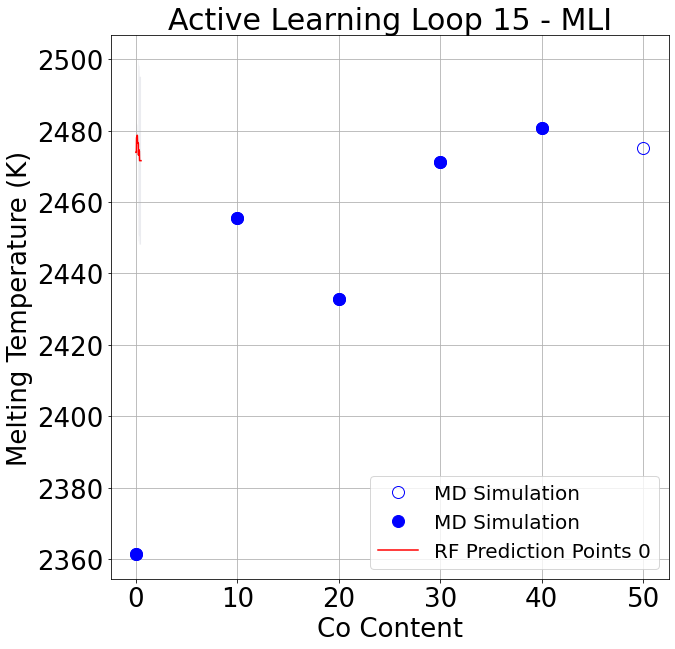

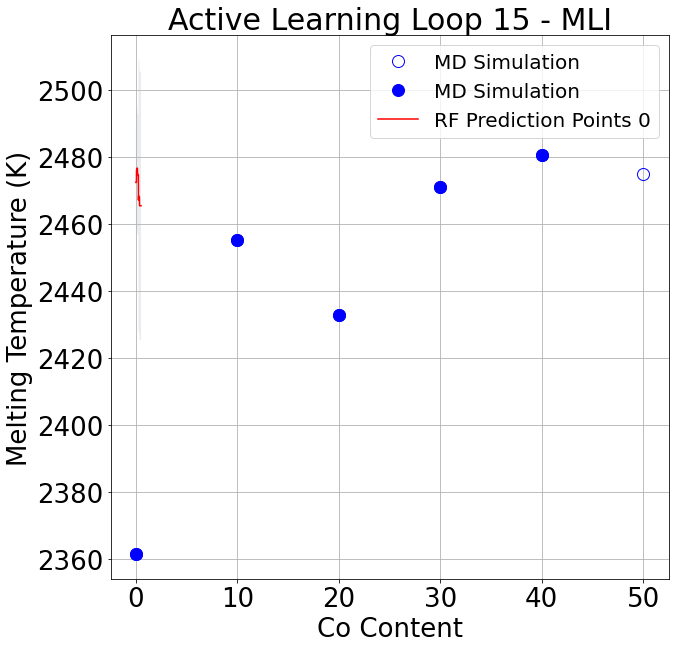

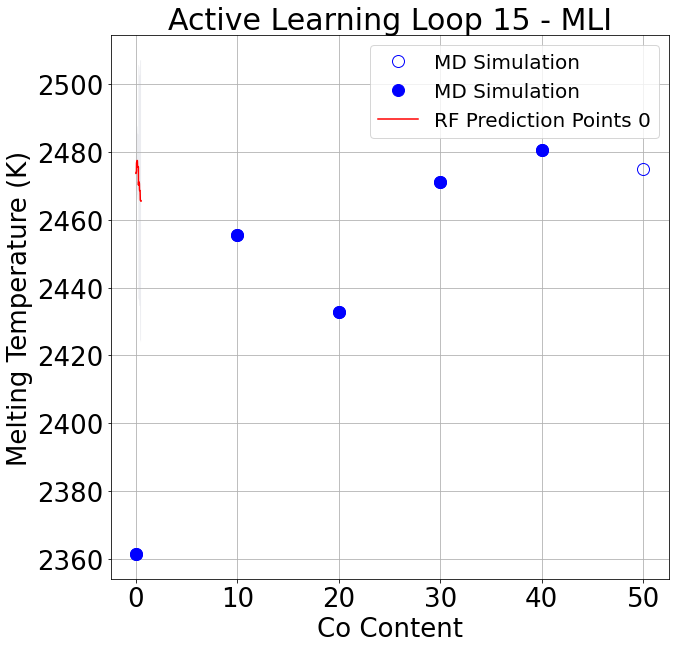

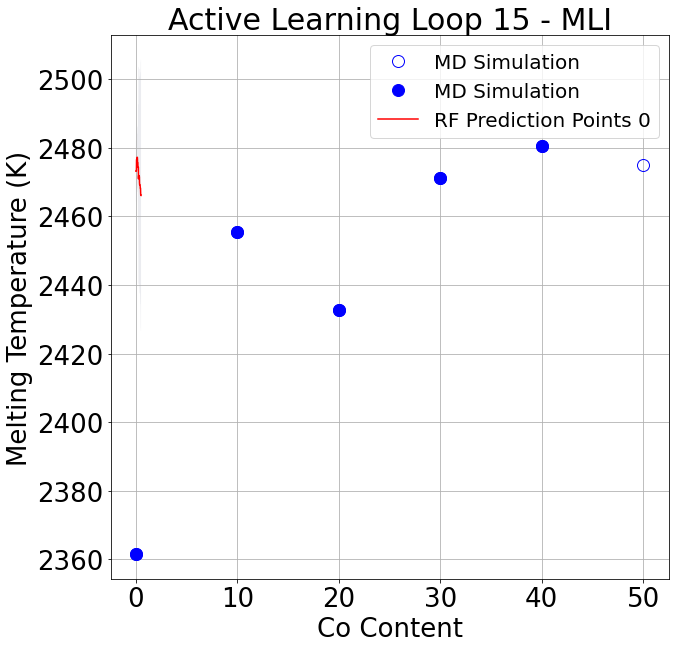

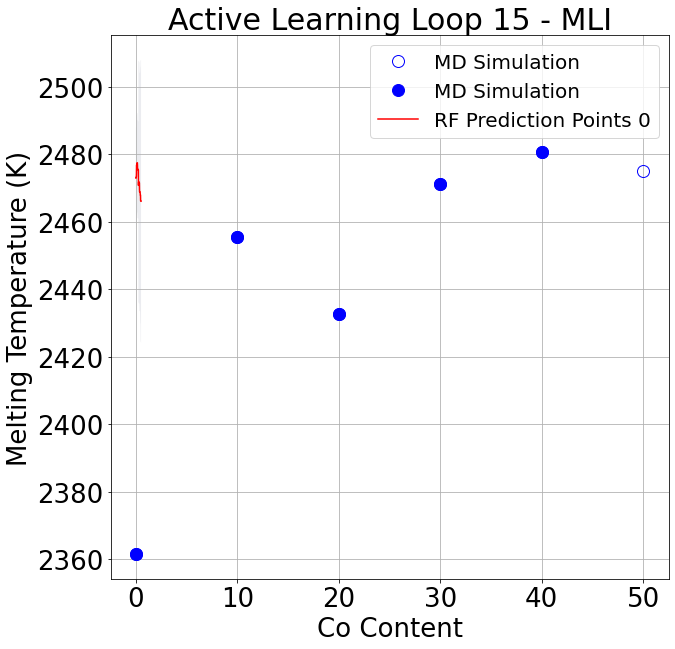

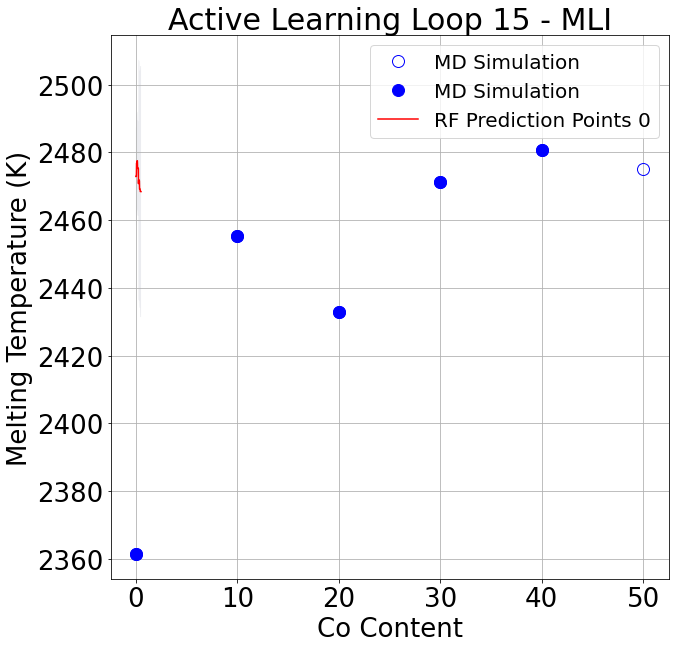

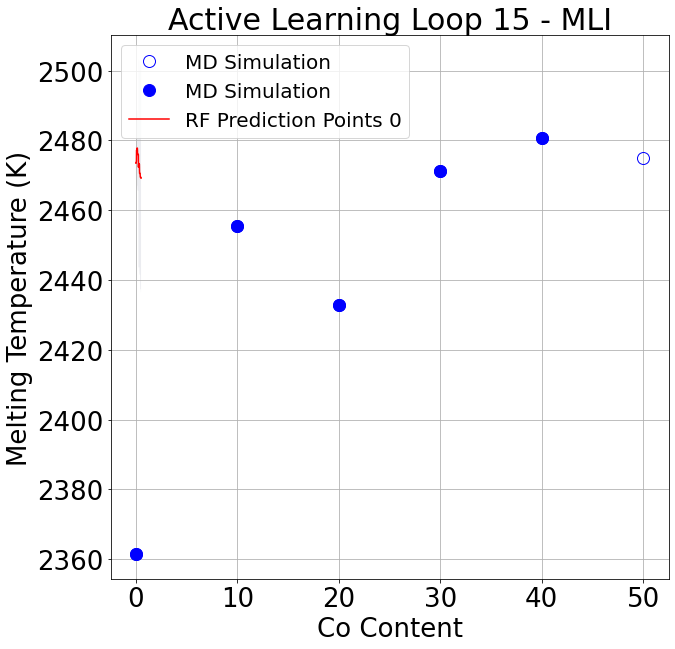

In [43]:
array_figures = []
#[2474,2472,2469,2485,2473,2539.428263]

colour = ['red','blue','green','brown']
colour_back = ['pink','blue','#00FF00','#EBECF0']
cobaltFill = [0,10,20,30,40,50]
#properInfo_arrayTreeVary = np.array(properInfo_arrayTreeVary)

index_outerLoop = 0
index = 0

for properInfo_array in properInfo_arrayTreeVary:
    
    index_innerLoop = 0

    for properInfo in properInfo_array:
        fig = plt.figure(figsize =(10,10))

        plt.plot(cobaltFill[:],initial_data['Simulated Tm'][10:16], color='blue', marker='o', fillstyle='none', markersize=12, linestyle = "None",  label = "MD Simulation")

        if index_outerLoop == 3:
            plt.plot(cobaltFill[0:5],initial_data['Simulated Tm'][10:15], color='blue', marker='o', fillstyle='full', markersize=12, linestyle = "None",  label = "MD Simulation")

        plt.plot(properInfo['Co'],properInfo['InitialRFPrediction'], color=colour[index_innerLoop], linestyle='solid',label='RF Prediction Points ' + str(points[index_innerLoop]))
        plt.fill_between(np.array(properInfo['Co']), np.array(properInfo['InitialRFPrediction'])-np.array(properInfo['InitialRFUncertaintity']), np.array(properInfo['InitialRFPrediction'])+np.array(properInfo['InitialRFUncertaintity'])
                         , facecolor='#EBECF0')

        plt.grid()
        plt.title('Active Learning Loop {0} - MLI'.format(index_outerLoop*5),fontsize=30)
        plt.legend(fontsize=20)
        plt.xlabel("Co Content", fontsize =26)
        plt.ylabel("Melting Temperature (K)", fontsize =26)
        plt.xticks(fontsize=26)
        plt.yticks(fontsize=26)
        array_figures.append(fig)


        index = index + 1
        
    index_outerLoop = index_outerLoop + 1

# Group Graph

In [44]:
#Adjust values to be percent instead of decimal
if properInfo_arrayTreeVary[0][6]['Co'][49]/100 == 0.5:
    print('already proper scale')
else:
    for stem in range(0,len(properInfo_arrayTreeVary)):
        index = 0
        for ct in properInfo_arrayTreeVary[stem][6]['Co']:
            properInfo_arrayTreeVary[stem][6]['Co'][index] = properInfo_arrayTreeVary[stem][6]['Co'][index]*100 
            index = index + 1

/apps/share64/debian7/anaconda/anaconda-6/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [45]:
#Get points of best compositions
if time == 50:
    graph_line = np.array(initial_data['Simulated Tm'][12:15])
    graph_line = np.append(graph_line,np.array(initial_data['Simulated Tm'][16:19]))
elif time == 100:
    graph_line = np.array(initial_data['Simulated Tm'][10:16])
elif time == 200:
    graph_line = np.array(initial_data['Simulated Tm'][13:18])
    graph_line = np.append(graph_line,np.array(initial_data['Simulated Tm'][19]))

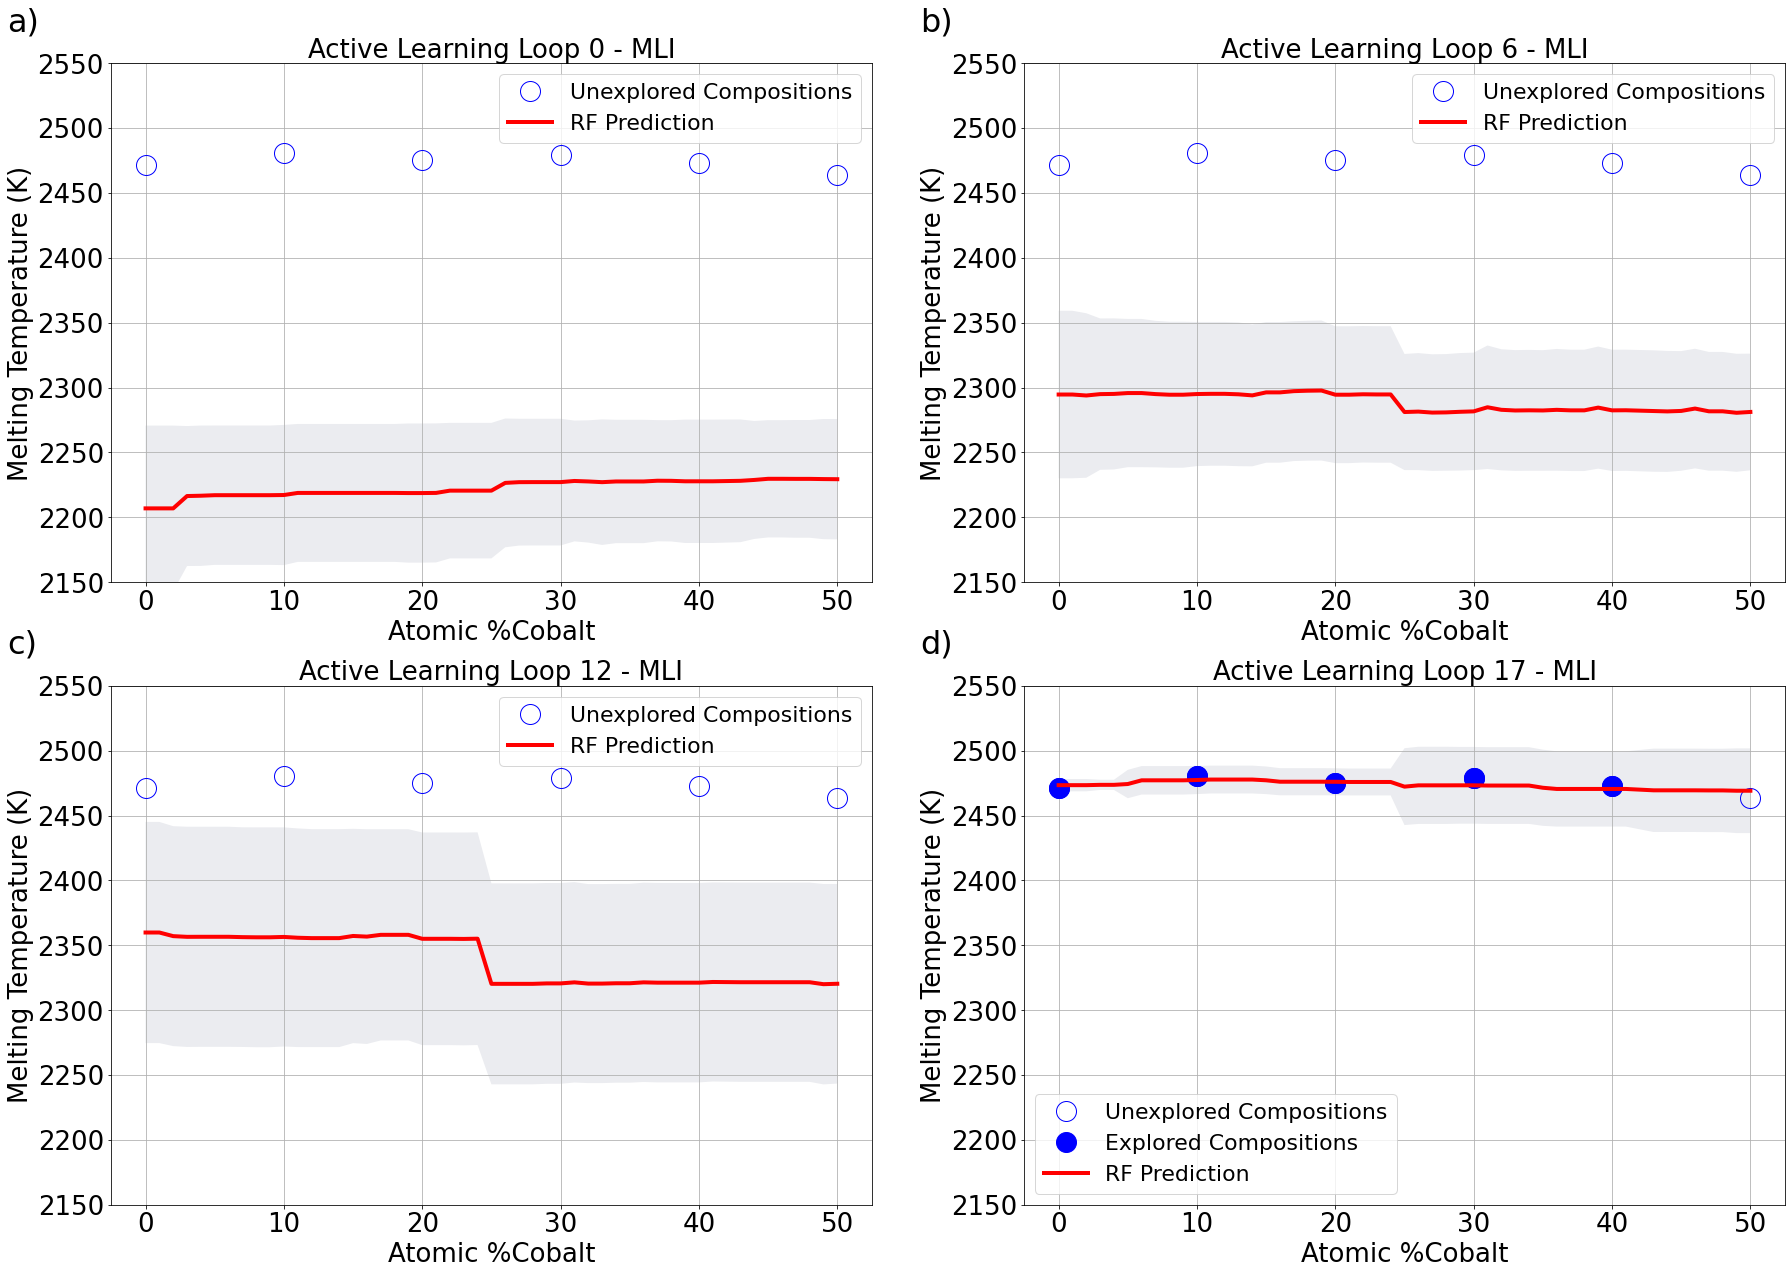

In [46]:
#make plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, gridspec_kw={'width_ratios': [100, 100]})
fig.set_size_inches(30, 21)

subplots_array = [ax1,ax2,ax3,ax4]
letter_panels = ['a','b','c','d']

plt.xticks(fontsize=26)
plt.yticks(fontsize=26)

index = 0
for index in range(0,len(properInfo_arrayTreeVary)):
    subplots_array[index].plot(cobaltFill[:],graph_line, color='blue', marker='o', fillstyle='none', markersize=20, linestyle = "None",  label = "Unexplored Compositions")
    
    if index == 3:
        plt.plot(cobaltFill[0:5],graph_line[0:5], color='blue', marker='o', fillstyle='full', markersize=20, linestyle = 'None',  label = "Explored Compositions")

    subplots_array[index].plot(properInfo_arrayTreeVary[index][6]['Co'],properInfo_arrayTreeVary[index][6]['InitialRFPrediction'], color=colour[index_innerLoop], linestyle='-',linewidth=4,label='RF Prediction')
    subplots_array[index].fill_between(np.array(properInfo['Co']), np.array(properInfo_arrayTreeVary[index][6]['InitialRFPrediction'])-np.array(properInfo_arrayTreeVary[index][6]['InitialRFUncertaintity']), 
                          np.array(properInfo_arrayTreeVary[index][6]['InitialRFPrediction'])+np.array(properInfo_arrayTreeVary[index][6]['InitialRFUncertaintity']), facecolor='#EBECF0')
    
    subplots_array[index].text(-10,2575,'{0})'.format(letter_panels[index]),fontsize=32)

    subplots_array[index].grid()
    if index == 0:
        subplots_array[index].set_title('Active Learning Loop {0} - MLI'.format(points[index]),fontsize=26)
    else:
        subplots_array[index].set_title('Active Learning Loop {0} - MLI'.format(points[index]-1),fontsize=26)
    
    subplots_array[index].set_xlabel('Atomic %Cobalt', fontsize=26)
    subplots_array[index].set_ylabel('Melting Temperature (K)', fontsize=26)
    
    subplots_array[index].xaxis.set_tick_params(labelsize=26)
    subplots_array[index].yaxis.set_tick_params(labelsize=26)
    
    subplots_array[index].set_ylim([2150, 2550])
    subplots_array[index].legend(fontsize=22)

    array_figures.append(fig)